In [373]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

# Optional: also set width to avoid line wrapping
pd.set_option('display.width', None)

# Optional: disable column width truncation
pd.set_option('display.max_colwidth', None)

In [ ]:
all_players = nfl.import_players()
all_qbs = all_players[all_players['position'] == 'QB']
all_qbs.reset_index(inplace=True, drop='index')
all_qbs_id = list(all_qbs.gsis_id)

[1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023]

In [487]:
weekly_data = nfl.import_weekly_data(years=[i for i in range(1999,2025)])
weekly_data['completion_pct'] = weekly_data.completions / weekly_data.attempts
weekly_relevant = weekly_data[weekly_data['player_id'].isin(all_qbs_id)][['player_id', 'season', 'passing_tds', 'interceptions', 
                                                                          'sacks', 'sack_fumbles', 'rushing_tds', 
                                                                          'rushing_fumbles', 'completion_pct', 'passing_air_yards', 'attempts',
                                                                          'passing_yards', 'passing_epa', 'rushing_epa']]
weekly_relevant = weekly_relevant.groupby(['player_id', 'season']).agg({
    'passing_tds' : 'sum', 
    'interceptions' : 'sum',
    'sacks' : 'sum',
    'sack_fumbles' : 'sum',
    'rushing_tds' : 'sum',
    'rushing_fumbles' : 'sum', 
    'completion_pct' : 'mean',
    'passing_air_yards' : 'sum',
    'attempts' : 'sum',
    'player_id' : 'count',
    'passing_yards' : 'sum',
    'passing_epa' : 'sum',
    'rushing_epa' : 'sum'})

weekly_relevant = weekly_relevant.rename(columns={'player_id' : 'games_played'})
weekly_relevant = weekly_relevant[(weekly_relevant['attempts'] > 200) & (weekly_relevant['games_played'] > 8)]
weekly_relevant = weekly_relevant.reset_index()


Downcasting floats.


In [488]:
stats2024 = nfl.import_pbp_data(years=[i for i in range(1999,2025)])
stats2024 = stats2024[(stats2024['qb_kneel'] == 0.0) & (stats2024['play_type'] != 'no_play')]
relevant = stats2024[['play_type', 'shotgun', 'qb_dropback', 'qb_scramble', 'air_yards', 'rushing_yards', 'id', 'season']]

1999 done.
2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


In [493]:
relevant = relevant.rename(columns={'id' : 'player_id'})
pass_stats = relevant[relevant['play_type'] == 'pass'].groupby(['player_id', 'season']).agg({'shotgun' : sum, 'qb_dropback' : sum})
pass_stats['shotgun'] = pass_stats.shotgun / pass_stats.qb_dropback
pass_stats.columns = ['shotgun_rate', 'total_passes']
pass_stats = pass_stats.reset_index()

In [494]:
weekly_relevant

,player_id,season,passing_tds,interceptions,sacks,sack_fumbles,rushing_tds,rushing_fumbles,completion_pct,passing_air_yards,attempts,games_played,passing_yards,passing_epa,rushing_epa
0,00-0000104,1999,17,11.0,20.0,5,1,2.0,0.604938,0.0,466,15,3206.0,39.995293,-8.846872
1,00-0000104,2000,7,14.0,13.0,2,0,0.0,0.567402,0.0,259,11,1616.0,-29.087923,-2.118868
2,00-0000722,1999,16,8.0,33.0,9,0,2.0,0.524115,0.0,318,11,2093.0,-31.089670,-5.022597
3,00-0000722,2000,8,8.0,20.0,4,0,1.0,0.419681,0.0,275,14,1538.0,-19.097155,-11.708343
4,00-0000722,2001,10,10.0,29.0,2,2,8.0,0.536239,0.0,370,15,2386.0,-38.900604,-9.998593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,00-0039164,2024,8,12.0,14.0,3,6,6.0,0.508737,3224.0,264,11,1814.0,-38.218216,22.734995
832,00-0039732,2024,30,12.0,26.0,2,4,1.0,0.659797,4376.0,589,18,3919.0,27.950514,24.429207
833,00-0039851,2024,15,10.0,34.0,5,2,4.0,0.595147,2473.0,338,13,2276.0,-27.612309,20.108276
834,00-0039910,2024,30,10.0,51.0,2,7,3.0,0.701405,4275.0,594,20,4390.0,89.848495,61.298084


In [507]:
run_stats = relevant[relevant['play_type'] == 'run'].groupby(['player_id', 'season']).agg({'qb_scramble' : ['sum', 'count'], 'rushing_yards' : 'sum'})
run_stats.columns = ['qb_scramble_sum', 'total_runs', 'rushing_yards']
run_stats['qb_scramble_rate'] = run_stats.qb_scramble_sum / run_stats.total_runs
run_stats = run_stats[['qb_scramble_rate', 'total_runs', 'rushing_yards']]
run_stats = run_stats.reset_index()
run_stats

,player_id,season,qb_scramble_rate,total_runs,rushing_yards
0,0,2000,0.000000,1,0.0
1,00-0000003,1999,0.006993,143,443.0
2,00-0000003,2000,0.000000,1,-2.0
3,00-0000007,1999,0.000000,5,12.0
4,00-0000007,2000,0.000000,16,70.0
...,...,...,...,...,...
8729,00-0039917,2024,0.800000,5,14.0
8730,00-0039918,2024,0.666667,75,495.0
8731,00-0039919,2024,0.000000,3,15.0
8732,00-0039920,2024,0.000000,2,26.0


In [509]:
total_data = weekly_relevant.merge(pass_stats, left_on=['player_id', 'season'], right_on=['player_id', 'season'])
total_data = total_data.merge(run_stats, left_on=['player_id', 'season'], right_on=['player_id', 'season'])
total_data.set_index(['player_id', 'season'])
#total_data = weekly_relevant.join(pass_stats).join(run_stats)

total_data['sacks_per_dropback'] = total_data['sacks'] / total_data['total_passes']
total_data['sack_fumbles'] = total_data['sack_fumbles'] / total_data['total_passes']

total_data['interceptions_per_game'] = total_data['interceptions'] / total_data['games_played']
total_data['passing_tds_per_game'] = total_data['passing_tds'] / total_data['games_played']
total_data['passing_air_yards_per_attempt'] = total_data['passing_air_yards'] / total_data['attempts']
total_data['passing_yards_per_game'] = total_data['passing_yards'] / total_data['games_played']

total_data['rushing_tds_per_game'] = total_data['rushing_tds'] / total_data['games_played']
total_data['rushing_fumbles_per_game'] = total_data['rushing_fumbles'] / total_data['games_played']
total_data['rushing_yards_per_game'] = total_data['rushing_yards'] / total_data['games_played']
total_data['rushing_yards_per_attempt'] = total_data['rushing_yards'] / total_data['total_runs']

total_data['pass_pct'] = total_data.total_passes / (total_data.total_passes + total_data.total_runs)

total_data['runs_per_game'] = total_data['total_runs'] / total_data['games_played']
total_data['attempts_per_game'] = total_data['attempts'] / total_data['games_played']

total_data['td:int'] = total_data['passing_tds'] / total_data['interceptions']
total_data['air_yard:completion_pct'] = total_data['passing_air_yards_per_attempt'] / total_data['completion_pct']

total_data = total_data[['player_id', 'season', 'sacks_per_dropback', 'attempts_per_game', 'rushing_tds_per_game', 'passing_tds_per_game', 'interceptions', 
                         'shotgun_rate', 'passing_air_yards_per_attempt', 'completion_pct',
                         'rushing_fumbles_per_game', 'rushing_yards_per_game', 'rushing_yards_per_attempt', 'pass_pct',
                         'air_yard:completion_pct', 'td:int']]

In [535]:
df = total_data.reset_index().merge(all_qbs[['gsis_id', 'display_name']], left_on='player_id', right_on='gsis_id')

qb_names = [(x['season'], x['display_name']) for idx, x in df.iterrows()]
qb_names

[(1999, 'Troy Aikman'),
 (2000, 'Troy Aikman'),
 (1999, 'Tony Banks'),
 (2000, 'Tony Banks'),
 (2001, 'Tony Banks'),
 (1999, 'Charlie Batch'),
 (2000, 'Charlie Batch'),
 (2001, 'Charlie Batch'),
 (1999, 'Steve Beuerlein'),
 (2000, 'Steve Beuerlein'),
 (1999, 'Jeff Blake'),
 (2000, 'Jeff Blake'),
 (2002, 'Jeff Blake'),
 (2003, 'Jeff Blake'),
 (1999, 'Drew Bledsoe'),
 (2000, 'Drew Bledsoe'),
 (2002, 'Drew Bledsoe'),
 (2003, 'Drew Bledsoe'),
 (2004, 'Drew Bledsoe'),
 (2005, 'Drew Bledsoe'),
 (2000, 'Aaron Brooks'),
 (2001, 'Aaron Brooks'),
 (2002, 'Aaron Brooks'),
 (2003, 'Aaron Brooks'),
 (2004, 'Aaron Brooks'),
 (2005, 'Aaron Brooks'),
 (1999, 'Mark Brunell'),
 (2000, 'Mark Brunell'),
 (2001, 'Mark Brunell'),
 (2002, 'Mark Brunell'),
 (2004, 'Mark Brunell'),
 (2005, 'Mark Brunell'),
 (2006, 'Mark Brunell'),
 (1999, 'Chris Chandler'),
 (2000, 'Chris Chandler'),
 (2001, 'Chris Chandler'),
 (1999, 'Kerry Collins'),
 (2000, 'Kerry Collins'),
 (2001, 'Kerry Collins'),
 (2002, 'Kerry Collins'

In [536]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
total_data

sacks_per_dropback  attempts_per_game  \
player_id  season                                          
00-0000104 1999              0.041152          31.066667   
           2000              0.047619          23.545455   
00-0000722 1999              0.094017          28.909091   
           2000              0.067797          19.642857   
           2001              0.072319          24.666667   
...                               ...                ...   
00-0039164 2024              0.050542          24.000000   
00-0039732 2024              0.042276          32.722222   
00-0039851 2024              0.090909          26.000000   
00-0039910 2024              0.078704          29.700000   
00-0039918 2024              0.106918          33.058824   

                   rushing_tds_per_game  passing_tds_per_game  interceptions  \
player_id  season                                                              
00-0000104 1999                0.066667              1.133333           11.0   
           2000                0.000000              0.636364           14.0   
00-0000722 1999                0.000000              1.454545            8.0   
           2000                0.000000              0.571429            8.0   
           2001                0.133333              0.666667           10.0   
...                                 ...                   ...            ...   
00-0039164 2024                0.545455              0.727273           12.0   
00-0039732 2024                0.222222              1.666667           12.0   
00-0039851 2024                0.153846              1.153846           10.0   
00-0039910 2024                0.350000              1.500000           10.0   
00-0039918 2024                0.000000              1.176471            6.0   

                   shotgun_rate  passing_air_yards_per_attempt  \
player_id  season                                                
00-0000104 1999        0.320988                       0.000000   
           2000        0.003663                       0.000000   
00-0000722 1999        0.173789                       0.000000   
           2000        0.179661                       0.000000   
           2001        0.256858                       0.000000   
...                         ...                            ...   
00-0039164 2024        0.960289                      12.212121   
00-0039732 2024        0.856911                       7.429542   
00-0039851 2024        0.882353                       7.316568   
00-0039910 2024        0.962963                       7.196970   
00-0039918 2024        0.860063                       7.982206   

                   completion_pct  rushing_fumbles_per_game  \
player_id  season                                             
00-0000104 1999          0.604938                  0.133333   
           2000          0.567402                  0.000000   
00-0000722 1999          0.524115                  0.181818   
           2000          0.419681                  0.071429   
           2001          0.536239                  0.533333   
...                           ...                       ...   
00-0039164 2024          0.508737                  0.545455   
00-0039732 2024          0.659797                  0.055556   
00-0039851 2024          0.595147                  0.307692   
00-0039910 2024          0.701405                  0.150000   
00-0039918 2024          0.626378                  0.176471   

                   rushing_yards_per_game  rushing_yards_per_attempt  \
player_id  season                                                      
00-0000104 1999                  1.266667                   1.583333   
           2000                  1.181818                   1.300000   
00-0000722 1999                  8.727273                   4.571429   
           2000                  4.000000                   2.947368   
           2001                 10.133333                   3.234043   
...           

In [537]:
scaler = StandardScaler()
X = scaler.fit_transform(total_data)
for P in range(1, 10):
    pca = PCA(n_components=P)
    pca.fit(X)
    print(pca.explained_variance_ratio_.sum())

pca = PCA(n_components=7)
X_pca = pca.fit_transform(X)


0.2510470324121162
0.49544490541099595
0.6165099624410073
0.7182316112912088
0.7884865329730897
0.838963816702917
0.8852784988774501
0.9176010601799967
0.9477446036723567


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of

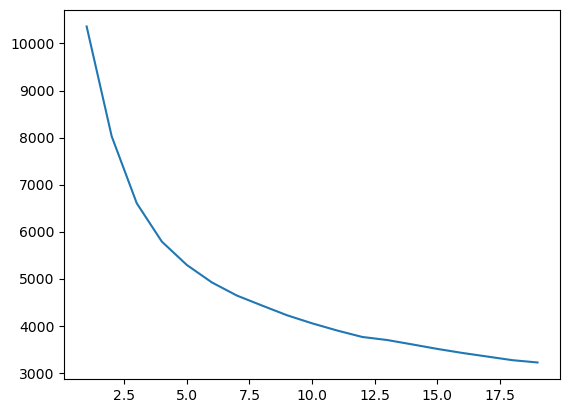

In [546]:
import plotly.express as px
intertia = []
for K in range(1,20):
    kmeans = KMeans(n_clusters=K)
    intertia.append(kmeans.fit(X= X_pca).inertia_)

kmeans = KMeans(n_clusters=7)
groups = kmeans.fit_predict(X=X_pca)
    
plt.plot(range(1,20), intertia)
plt.show()
fig = px.scatter(x=X_pca[:, 0], y=X_pca[:,1], color=groups, hover_name=qb_names)
fig.show()

In [539]:
tier_list = weekly_relevant.merge(pass_stats, left_on=['player_id', 'season'], right_on=['player_id', 'season'])
tier_list = tier_list.merge(run_stats, left_on=['player_id', 'season'], right_on=['player_id', 'season'])
tier_list['tds_per_game'] = (tier_list['passing_tds'] + tier_list['rushing_tds']) / tier_list['games_played']
tier_list['yards_per_game'] = (tier_list['passing_yards'] + tier_list['rushing_yards'])/ tier_list['games_played']
tier_list['passing_yards_per_attempt'] = tier_list['passing_yards'] / tier_list['attempts']
tier_list['rushing_yards_per_run']  = tier_list['rushing_yards'] / tier_list['total_runs']
tier_list['turnovers_per_game'] = (tier_list['interceptions'] + tier_list['sack_fumbles'] + tier_list['rushing_fumbles']) / tier_list['games_played']
tier_list['td:turnover'] = tier_list['tds_per_game'] / tier_list['turnovers_per_game']
tier_list['passing_epa_per_game'] = tier_list['passing_epa'] / tier_list['games_played']
tier_list['rushing_epa_per_game'] = tier_list['rushing_epa'] / tier_list['games_played']


tier_list = tier_list[['tds_per_game', 'yards_per_game', 'passing_yards_per_attempt', 'rushing_yards_per_run', 
                       'turnovers_per_game', 'td:turnover', 'completion_pct', 'passing_epa_per_game', 'rushing_epa_per_game']]
tier_list.columns

Index(['tds_per_game', 'yards_per_game', 'passing_yards_per_attempt',
       'rushing_yards_per_run', 'turnovers_per_game', 'td:turnover',
       'completion_pct', 'passing_epa_per_game', 'rushing_epa_per_game'],
      dtype='object')

In [540]:
tiered_pca = PCA(n_components=1)
scaler = StandardScaler()
X = scaler.fit_transform(tier_list)
ranks = tiered_pca.fit_transform(X)
ranked_df = pd.DataFrame(data=[qb_names, ranks]).T.reset_index(drop='index').set_index(0)
ranked_df.columns = ['scores']
ranked_df['scores'] = ranked_df['scores'].apply(lambda x : x[0])


In [541]:
ranked_df.sort_values('scores', ascending=False).head(25)

,scores
0,
"(2020, Aaron Rodgers)",6.966155
"(2011, Aaron Rodgers)",6.872441
"(2011, Drew Brees)",6.167853
"(2016, Matt Ryan)",5.966620
"(2004, Peyton Manning)",5.571231
"(2007, Tom Brady)",5.511696
"(2018, Patrick Mahomes)",5.281755
"(2019, Drew Brees)",5.215108
"(2024, Lamar Jackson)",5.186852
